## <span style="color:green"><h1><center>Part 2: CAMELS-Like Data Preparation for USGS Basins – Hydrometeorological Time Series</center></h1></span>

<center>Prepared by <br>
<b>Mohammad Galib and Venkatesh Merwade</b><br> 
Lyles School of Civil Engineering, Purdue University<br>
mgalib@purdue.edu, vmerwade@purdue.edu<br>
<b><br>
FAIR Science in Water Resources</b><br></center>

---

## <span style="color:green">1. Objective</span>

<p style='text-align: justify;'>This tutorial guides users through the process of downloading and formatting hydrometeorological forcing data to create CAMELS-like time series for any USGS watershed. We use gridded datasets such as GridMET and derive potential evapotranspiration (PET) to match the structure used in CAMELS.</p>

## <span style="color:green">2. Overview</span>

<p style='text-align: justify;'>CAMELS uses gridded meteorological datasets like Daymet, Maurer, and NLDAS to generate consistent daily forcing data for all watersheds. Here, we focus on GridMET due to its high spatial resolution, wide coverage, and reliability. We retrieve data using the <code>pygridmet</code> library and calculate derived variables like PET to replicate CAMELS forcing format.</p>

**Why GridMET?**
- High spatial resolution (~4km)
- Covers CONUS comprehensively
- Multiple climate variables available
- Regularly updated and maintained
- More reliable access compared to Daymet

## <span style="color:green">3. Forcing Variables</span>

| Variable                          | Source       | Included in CAMELS | Notes                                           |
|----------------------------------|--------------|---------------------|-------------------------------------------------|
| Precipitation (mm)               | GridMET      | ✅                  | Daily total precipitation                       |
| Tmax, Tmin (°C)                  | GridMET      | ✅                  | Daily max/min air temperature                   |
| Shortwave Radiation (W/m²)       | GridMET      | ✅                  | Solar radiation                                 |
| Vapor Pressure (kPa)             | GridMET      | ✅                  | Proxy for humidity                              |
| Wind Speed (m/s)                 | GridMET      | ✅                  | Surface wind speed                              |
| Relative Humidity (%)            | GridMET      | ✅                  | Can be derived from other variables             |
| Potential Evapotranspiration     | Derived      | ✅                  | Computed using Penman-Monteith or other methods |

**Note:** GridMET provides more complete meteorological forcing data compared to Daymet, making it ideal for hydrological modeling.

## <span style="color:green">4. Python Implementation</span>

### 4.1 Import Required Libraries

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from typing import Union

# Hydrological and geospatial libraries
import pygridmet as gridmet
from pygeohydro import NWIS
from pynhd import NLDI

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("All libraries loaded successfully!")

All libraries loaded successfully!


### 4.2 Function: Get USGS Watershed Shapefile

This function retrieves the watershed boundary for a given USGS gauge.

In [2]:
def get_usgs_watershed_shapefile(gage_id: str, output_path: str = None, plot: bool = False) -> gpd.GeoDataFrame:
    """
    Get watershed boundary for a USGS gauge using NLDI service.
    
    Parameters:
    -----------
    gage_id : str
        USGS gauge identifier
    output_path : str, optional
        Path to save shapefile
    plot : bool, optional
        Whether to plot the watershed
        
    Returns:
    --------
    gpd.GeoDataFrame
        Watershed boundary
    """
    try:
        # Use NLDI for watershed delineation
        nldi = NLDI()
        boundary_gdf = nldi.get_basins(gage_id)
        
        # Ensure CRS is WGS84
        if boundary_gdf.crs != 'EPSG:4326':
            boundary_gdf = boundary_gdf.to_crs('EPSG:4326')
        
        if output_path:
            boundary_gdf.to_file(output_path)
            print(f"Watershed shapefile saved to: {output_path}")
        
        if plot:
            fig, ax = plt.subplots(figsize=(10, 8))
            boundary_gdf.plot(ax=ax, edgecolor='k', facecolor='lightblue', alpha=0.7)
            ax.set_title(f"Watershed for USGS Gage {gage_id}", fontsize=14, fontweight='bold')
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        # Calculate and print area
        area_km2 = boundary_gdf.to_crs('EPSG:5070').geometry.area.iloc[0] / 1e6
        print(f"Watershed area: {area_km2:.2f} km²")
        
        return boundary_gdf
        
    except Exception as e:
        print(f"Error delineating watershed: {e}")
        return None

### 4.3 Function: Fetch Climate Data from GridMET
This function downloads daily climate forcing data for the watershed using GridMET.
**Attributes Extracted:**
- **Precipitation (`prcp_mm`)**: Daily total precipitation (mm)
- **Temperature**: Daily minimum (`tmin_C`), maximum (`tmax_C`), and average (`tavg_C`) temperature (°C)
- **Radiation (`srad_Wm2`)**: Daily mean shortwave radiation (W/m²)
- **Wind (`wind_ms`)**: Daily mean wind speed (m/s)
- **Humidity (`sph_kgkg`)**: Specific humidity (kg/kg)
- **PET (`pet_mm`)**: Potential Evapotranspiration from GridMET (mm)

In [3]:
def fetch_climate_data_gridmet(watershed_geom, start_date: str, end_date: str) -> Union[pd.DataFrame, None]:
    """
    Fetch climate data from GridMET for watershed.
    
    Parameters:
    -----------
    watershed_geom : shapely.geometry
        Watershed boundary geometry
    start_date : str
        Start date (YYYY-MM-DD)
    end_date : str
        End date (YYYY-MM-DD)
        
    Returns:
    --------
    pd.DataFrame or None
        Daily climate forcing data
    """
    try:
        print(f"Fetching GridMET data from {start_date} to {end_date}...")
        
        # Define variables to fetch
        # pr = precipitation, tmmn = min temp, tmmx = max temp
        # srad = shortwave radiation, vs = wind speed, sph = specific humidity
        variables = ["pr", "tmmn", "tmmx", "srad", "vs", "sph", "pet"]
        
        # Fetch data using pygridmet
        ds = gridmet.get_bygeom(
            geometry=watershed_geom,
            dates=(start_date, end_date),
            variables=variables,
            crs="EPSG:4326",
        )
        
        print(f"✓ Retrieved {len(ds.time)} days of climate data")
        
        # Calculate spatial mean (watershed average)
        df_list = []
        
        for var in variables:
            if var in ds.data_vars:
                # Get spatial mean
                var_mean = ds[var].mean(dim=["lat", "lon"])
                series = var_mean.to_series()
                series.index = pd.to_datetime(series.index).tz_localize(None)
                df_list.append(series.rename(var))
        
        # Combine all variables
        df = pd.concat(df_list, axis=1)
        
        # Unit conversions
        df['tmmn'] = df['tmmn'] - 273.15  # K to °C
        df['tmmx'] = df['tmmx'] - 273.15  # K to °C
        df['tavg'] = (df['tmmn'] + df['tmmx']) / 2  # Average temperature
        
        # Rename columns to match CAMELS convention
        df = df.rename(columns={
            'pr': 'prcp_mm',
            'tmmn': 'tmin_C',
            'tmmx': 'tmax_C',
            'tavg': 'tavg_C',
            'srad': 'srad_Wm2',
            'vs': 'wind_ms',
            'sph': 'sph_kgkg',
            'pet': 'pet_mm'
        })
        
        df.index.name = 'date'
        df = df.reset_index()
        
        return df
        
    except Exception as e:
        print(f"✗ Error fetching GridMET data: {e}")
        return None

### 4.4 Function: Calculate Additional PET (Optional)
While GridMET provides PET, we also compute it using the **Hargreaves-Samani** method for comparison or as a backup.
**Attributes Computed:**
- **`pet_hargreaves_mm`**: PET estimated using temperature and solar radiation data (mm/day).

In [4]:
def calculate_pet_hargreaves(df: pd.DataFrame, latitude: float) -> pd.DataFrame:
    """
    Calculate PET using Hargreaves-Samani method.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with tmin_C, tmax_C, and srad_Wm2
    latitude : float
        Watershed centroid latitude
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with additional PET_hargreaves column
    """
    try:
        # Hargreaves-Samani equation
        # PET = 0.0023 * Ra * (Tavg + 17.8) * sqrt(Tmax - Tmin)
        # where Ra is extraterrestrial radiation (approximated from srad)
        
        tavg = (df['tmin_C'] + df['tmax_C']) / 2
        tdiff = np.sqrt(df['tmax_C'] - df['tmin_C'])
        
        # Simplified calculation using available solar radiation
        # Convert W/m² to MJ/m²/day (multiply by 0.0864)
        ra_approx = df['srad_Wm2'] * 0.0864 * 1.5  # rough approximation
        
        df['pet_hargreaves_mm'] = 0.0023 * ra_approx * (tavg + 17.8) * tdiff
        
        print("✓ Hargreaves-Samani PET calculated")
        return df
        
    except Exception as e:
        print(f"✗ Error calculating Hargreaves PET: {e}")
        return df

### 4.5 Function: Calculate Climate Indices
We derive long-term climate statistics to characterize the watershed's hydro-climatic regime.
**Indices Computed:**
- **Mean Annuals**: Precipitation, PET, and Temperature
- **Aridity Index**: Ratio of Mean Annual PET to Precipitation
- **Seasonality & Extremes**: Mean daily max/min temperatures
- **Precipitation Signatures**: Frequency of wet days (>1mm)
- **Snow Fraction**: Proportion of precipitation falling as snow (approximate)

In [5]:
def calculate_climate_statistics(df: pd.DataFrame) -> dict:
    """
    Calculate climate statistics from forcing data.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Climate forcing DataFrame
        
    Returns:
    --------
    dict
        Dictionary of climate statistics
    """
    stats = {}
    
    # Basic statistics
    stats['mean_annual_precip_mm'] = df['prcp_mm'].sum() / (len(df) / 365.25)
    stats['mean_annual_pet_mm'] = df['pet_mm'].sum() / (len(df) / 365.25)
    stats['mean_annual_temp_C'] = df['tavg_C'].mean()
    stats['aridity_index'] = stats['mean_annual_pet_mm'] / stats['mean_annual_precip_mm']
    
    # Temperature extremes
    stats['mean_tmax_C'] = df['tmax_C'].mean()
    stats['mean_tmin_C'] = df['tmin_C'].mean()
    
    # Precipitation statistics
    stats['wet_days'] = (df['prcp_mm'] > 1.0).sum()
    stats['wet_day_frequency'] = stats['wet_days'] / len(df)
    
    # Snow fraction (approximate)
    snow_days = (df['tavg_C'] <= 0) & (df['prcp_mm'] > 0)
    stats['snow_fraction'] = df.loc[snow_days, 'prcp_mm'].sum() / df['prcp_mm'].sum()
    
    return stats

### 4.6 Function: Create Summary Plots

In [6]:
def plot_climate_summary(df: pd.DataFrame, gage_id: str, output_dir: Path = None):
    """
    Create summary plots of climate forcing data.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Climate forcing DataFrame
    gage_id : str
        USGS gauge ID
    output_dir : Path, optional
        Directory to save plots
    """
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # Plot 1: Temperature
    axes[0].plot(df['date'], df['tmax_C'], 'r-', alpha=0.6, label='Tmax', linewidth=0.8)
    axes[0].plot(df['date'], df['tmin_C'], 'b-', alpha=0.6, label='Tmin', linewidth=0.8)
    axes[0].plot(df['date'], df['tavg_C'], 'k-', alpha=0.8, label='Tavg', linewidth=1.2)
    axes[0].set_ylabel('Temperature (°C)', fontsize=11)
    axes[0].set_title(f'Climate Forcing Data for USGS Gage {gage_id}', fontsize=13, fontweight='bold')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Precipitation and PET
    ax2 = axes[1]
    ax2.bar(df['date'], df['prcp_mm'], color='blue', alpha=0.6, label='Precipitation', width=1.0)
    ax2_twin = ax2.twinx()
    ax2_twin.plot(df['date'], df['pet_mm'], 'r-', label='PET', linewidth=1.0)
    ax2.set_ylabel('Precipitation (mm/day)', fontsize=11, color='blue')
    ax2_twin.set_ylabel('PET (mm/day)', fontsize=11, color='red')
    ax2.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Solar Radiation
    axes[2].plot(df['date'], df['srad_Wm2'], 'orange', linewidth=0.8)
    axes[2].set_ylabel('Solar Radiation (W/m²)', fontsize=11)
    axes[2].set_xlabel('Date', fontsize=11)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if output_dir:
        output_dir.mkdir(exist_ok=True, parents=True)
        plt.savefig(output_dir / f'{gage_id}_climate_summary.png', dpi=300, bbox_inches='tight')
        print(f"✓ Plot saved to: {output_dir / f'{gage_id}_climate_summary.png'}")
    
    plt.show()

### 4.7 Main Execution Function

In [7]:
def create_camels_forcing(gage_id: str, start_date: str, end_date: str, output_dir: Path):
    """
    Create complete CAMELS-like forcing dataset for a watershed.
    
    Parameters:
    -----------
    gage_id : str
        USGS gauge identifier
    start_date : str
        Start date (YYYY-MM-DD)
    end_date : str
        End date (YYYY-MM-DD)
    output_dir : Path
        Output directory for results
    """
    print(f"\n{'='*60}")
    print(f"Creating CAMELS-like forcing for USGS Gage {gage_id}")
    print(f"Period: {start_date} to {end_date}")
    print(f"{'='*60}\n")
    
    # Create output directory
    output_dir.mkdir(exist_ok=True, parents=True)
    
    # Step 1: Get watershed boundary
    print("Step 1: Delineating watershed...")
    gdf_watershed = get_usgs_watershed_shapefile(gage_id, plot=True)
    
    if gdf_watershed is None:
        print("Failed to delineate watershed. Exiting.")
        return None
    
    geom = gdf_watershed.geometry.iloc[0]
    
    # Step 2: Fetch climate data
    print("\nStep 2: Fetching climate data from GridMET...")
    df_climate = fetch_climate_data_gridmet(geom, start_date, end_date)
    
    if df_climate is None:
        print("Failed to fetch climate data. Exiting.")
        return None
    
    # Step 3: Calculate additional PET (optional)
    print("\nStep 3: Calculating additional PET methods...")
    centroid = gdf_watershed.to_crs('EPSG:4326').centroid.iloc[0]
    df_climate = calculate_pet_hargreaves(df_climate, centroid.y)
    
    # Step 4: Calculate climate statistics
    print("\nStep 4: Calculating climate statistics...")
    stats = calculate_climate_statistics(df_climate)
    
    print("\nClimate Statistics:")
    print("-" * 40)
    for key, value in stats.items():
        print(f"{key}: {value:.2f}")
    
    # Step 5: Save results
    print("\nStep 5: Saving results...")
    
    # Save forcing data
    forcing_file = output_dir / f"{gage_id}_gridmet_forcing.csv"
    df_climate.to_csv(forcing_file, index=False)
    print(f"✓ Forcing data saved: {forcing_file}")
    
    # Save statistics
    stats_file = output_dir / f"{gage_id}_climate_stats.csv"
    pd.DataFrame([stats]).to_csv(stats_file, index=False)
    print(f"✓ Statistics saved: {stats_file}")
    
    # Save watershed shapefile
    shp_dir = output_dir / "shapefiles"
    shp_dir.mkdir(exist_ok=True)
    gdf_watershed.to_file(shp_dir / f"{gage_id}_watershed.shp")
    print(f"✓ Watershed shapefile saved: {shp_dir}")
    
    # Step 6: Create plots
    print("\nStep 6: Creating summary plots...")
    plot_climate_summary(df_climate, gage_id, output_dir / "plots")
    
    print(f"\n{'='*60}")
    print("CAMELS-like forcing dataset creation complete!")
    print(f"{'='*60}\n")
    
    return df_climate, stats

## <span style="color:green">5. Execute the Workflow</span>

Now let's run the complete workflow for a specific USGS gauge.


Creating CAMELS-like forcing for USGS Gage 03335000
Period: 2010-01-01 to 2020-12-31

Step 1: Delineating watershed...


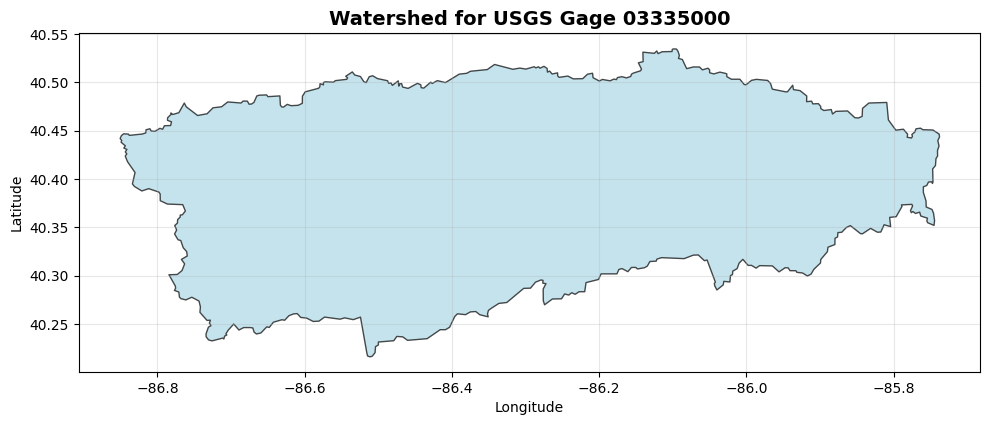

Watershed area: 2059.83 km²

Step 2: Fetching climate data from GridMET...
Fetching GridMET data from 2010-01-01 to 2020-12-31...
✓ Retrieved 4015 days of climate data

Step 3: Calculating additional PET methods...
✓ Hargreaves-Samani PET calculated

Step 4: Calculating climate statistics...

Climate Statistics:
----------------------------------------
mean_annual_precip_mm: 1106.93
mean_annual_pet_mm: 1105.08
mean_annual_temp_C: 11.06
aridity_index: 1.00
mean_tmax_C: 16.70
mean_tmin_C: 5.42
wet_days: 1273.00
wet_day_frequency: 0.32
snow_fraction: 0.07

Step 5: Saving results...
✓ Forcing data saved: camels_forcing_output/03335000_gridmet_forcing.csv
✓ Statistics saved: camels_forcing_output/03335000_climate_stats.csv
✓ Watershed shapefile saved: camels_forcing_output/shapefiles

Step 6: Creating summary plots...
✓ Plot saved to: camels_forcing_output/plots/03335000_climate_summary.png


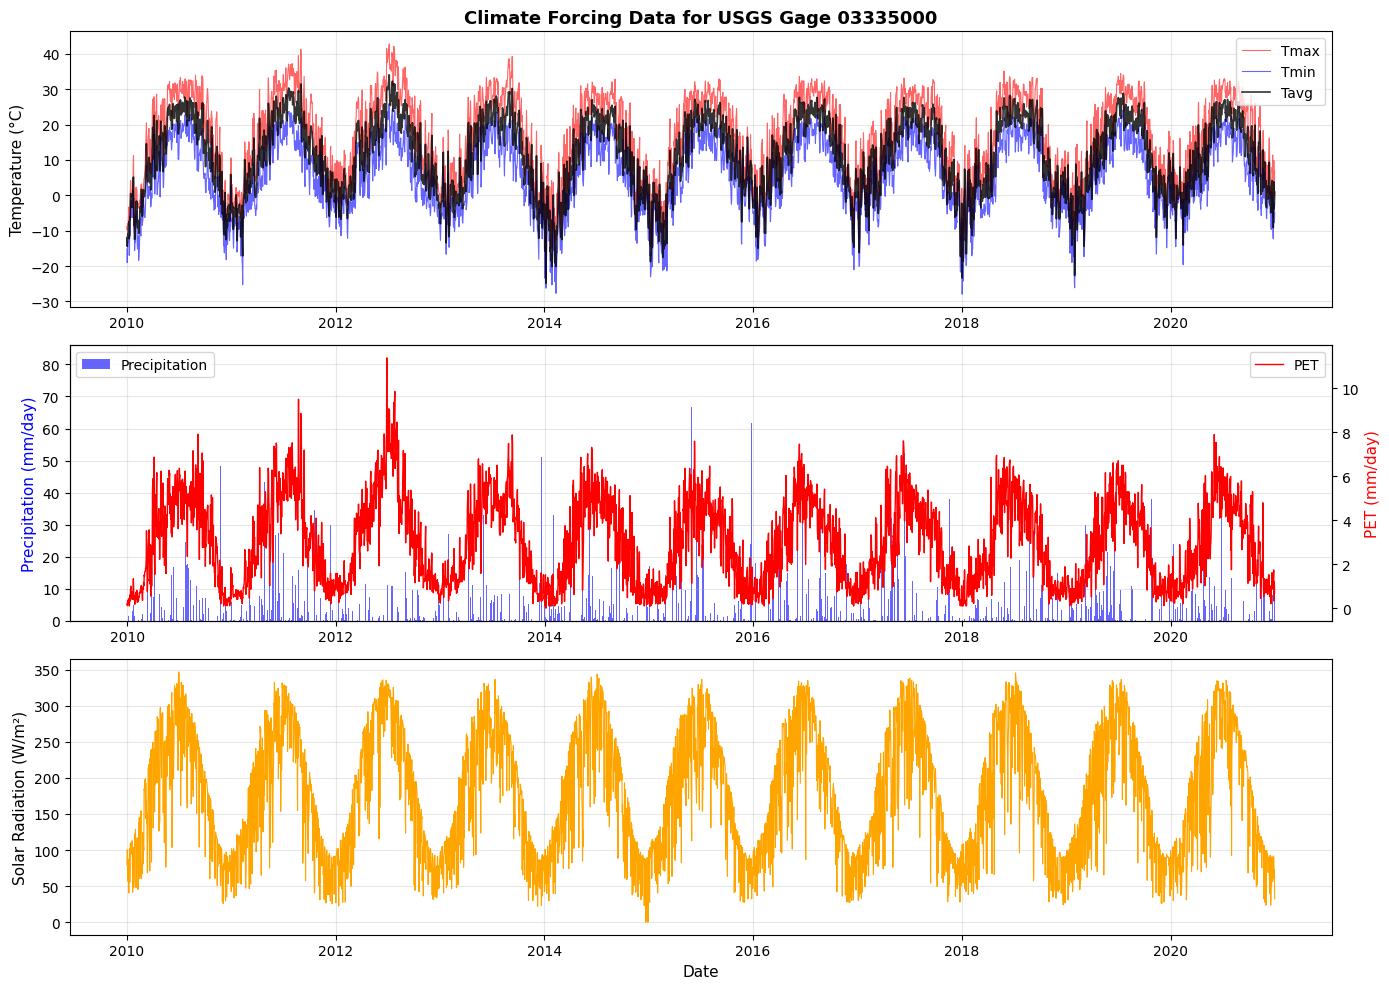


CAMELS-like forcing dataset creation complete!



In [20]:
# Define parameters
gage_id = "03335000"  # Wabash River at Lafayette, IN
start_date = "2010-01-01"
end_date = "2020-12-31"
output_dir = Path("./camels_forcing_output")

# Run the workflow
df_forcing, climate_stats = create_camels_forcing(gage_id, start_date, end_date, output_dir)

## <span style="color:green">6. View and Analyze Results</span>

### 6.1 Preview Forcing Data

In [22]:
# Display first few rows
print("First 10 rows of forcing data:")
print(df_forcing.head(10))

# Display summary statistics
print("\nSummary statistics:")
print(df_forcing.describe())

First 10 rows of forcing data:
        date   prcp_mm     tmin_C    tmax_C    srad_Wm2   wind_ms  sph_kgkg  \
0 2010-01-01  0.000000 -15.229095 -8.822845   79.410851  6.111628  0.001456   
1 2010-01-02  0.000000 -19.041473 -9.829071  100.337212  5.273643  0.001295   
2 2010-01-03  0.017054 -16.183319 -8.028290   95.522484  4.579845  0.001305   
3 2010-01-04  0.374419 -13.045349 -8.748444   60.451939  5.589923  0.001383   
4 2010-01-05  0.000000 -13.123657 -8.626740   56.528679  4.532558  0.001571   
5 2010-01-06  1.360465 -13.048431 -6.405060   86.727905  2.790698  0.001789   
6 2010-01-07  4.806976 -13.333710 -4.504272   41.946514  3.741085  0.001866   
7 2010-01-08  0.563566 -11.456940 -3.305023   40.444962  4.714729  0.001900   
8 2010-01-09  0.000000 -16.986420 -7.513550   81.309303  3.912403  0.001716   
9 2010-01-10  0.000000 -15.577148 -6.659302  101.662788  4.279070  0.001351   

     pet_mm     tavg_C  pet_hargreaves_mm  
0  0.187597 -12.025970           0.345934  
1  0.118605

### 6.2 Monthly Aggregation

Calculate monthly averages for better understanding of seasonal patterns.

In [23]:
# Calculate monthly statistics
df_forcing['year_month'] = pd.to_datetime(df_forcing['date']).dt.to_period('M')

monthly_summary = df_forcing.groupby('year_month').agg({
    'prcp_mm': 'sum',
    'pet_mm': 'sum',
    'tavg_C': 'mean',
    'tmax_C': 'mean',
    'tmin_C': 'mean',
    'srad_Wm2': 'mean'
}).reset_index()

print("\nMonthly summary (first 12 months):")
print(monthly_summary.head(12))


Monthly summary (first 12 months):
   year_month     prcp_mm      pet_mm     tavg_C     tmax_C     tmin_C  \
0     2010-01   30.844185   15.578295  -5.831838  -2.477753  -9.185924   
1     2010-02   33.379070   18.603102  -4.494965  -0.359317  -8.630612   
2     2010-03   99.475967   67.027130   6.087836  12.046377   0.129296   
3     2010-04   69.393021  125.839539  13.685550  20.597164   6.773935   
4     2010-05  129.465897  132.979843  17.613821  23.386641  11.841002   
5     2010-06  260.116272  147.660461  22.713097  28.113161  17.313030   
6     2010-07  112.186043  157.388367  24.164436  29.846207  18.482670   
7     2010-08   64.613953  157.667435  23.732878  29.962761  17.502996   
8     2010-09   33.541084  136.505432  18.804514  26.188534  11.420496   
9     2010-10   22.914730  106.626358  12.451906  20.206898   4.696917   
10    2010-11  113.802322   49.976746   5.214775  11.717912  -1.288363   
11    2010-12   34.341862   12.804651  -5.710258  -1.481404  -9.939113   

 

### 6.3 Water Balance Check

Calculate simple water balance metrics.


Annual water balance:
          prcp_mm       pet_mm  water_surplus_mm  aridity_index
year                                                           
2010  1004.074402  1128.657349       -124.582947       1.124077
2011  1287.893066  1163.891479        124.001587       0.903717
2012   881.012390  1332.937988       -451.925598       1.512962
2013  1127.083008  1136.700806         -9.617798       1.008533
2014  1068.759644  1045.727905         23.031738       0.978450
2015  1161.957397  1015.177551        146.779846       0.873679
2016  1000.335632  1077.787598        -77.451965       1.077426
2017  1319.540283  1097.075928        222.464355       0.831408
2018  1236.189941  1032.927856        203.262085       0.835574
2019  1095.015503  1022.958130         72.057373       0.934195
2020   986.050415  1093.745728       -107.695312       1.109219


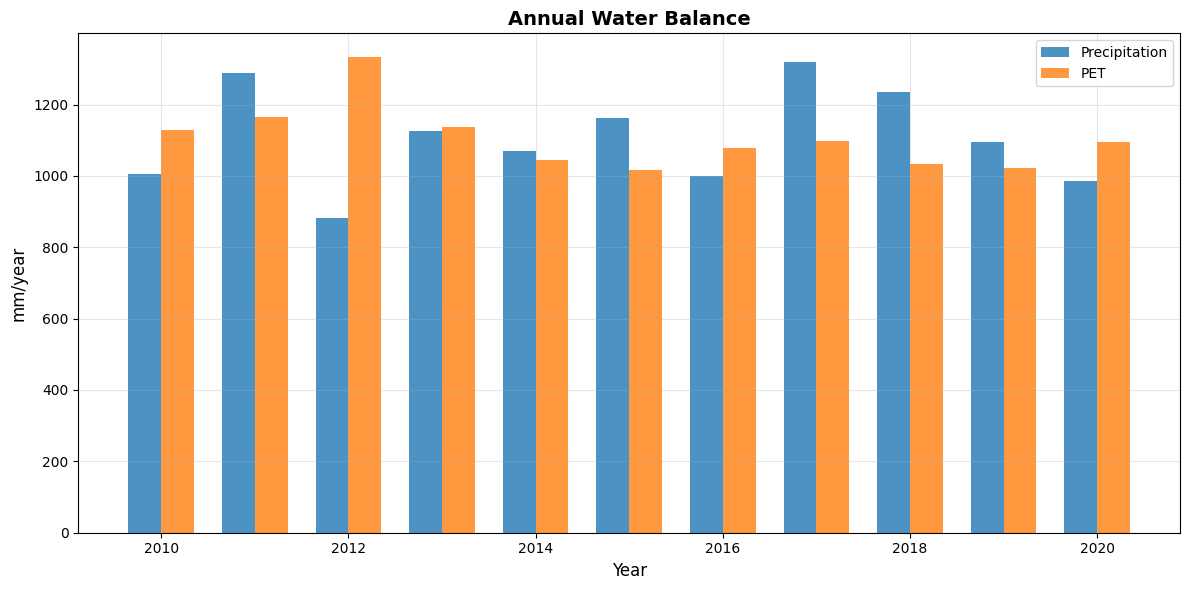

In [24]:
# Annual water balance
df_forcing['year'] = pd.to_datetime(df_forcing['date']).dt.year

annual_balance = df_forcing.groupby('year').agg({
    'prcp_mm': 'sum',
    'pet_mm': 'sum'
})

annual_balance['water_surplus_mm'] = annual_balance['prcp_mm'] - annual_balance['pet_mm']
annual_balance['aridity_index'] = annual_balance['pet_mm'] / annual_balance['prcp_mm']

print("\nAnnual water balance:")
print(annual_balance)

# Plot annual water balance
fig, ax = plt.subplots(figsize=(12, 6))
x = annual_balance.index
width = 0.35
ax.bar(x - width/2, annual_balance['prcp_mm'], width, label='Precipitation', alpha=0.8)
ax.bar(x + width/2, annual_balance['pet_mm'], width, label='PET', alpha=0.8)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('mm/year', fontsize=12)
ax.set_title('Annual Water Balance', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## <span style="color:green">7. Output Format</span>

### 7.1 Final Output Structure

| Column       | Description                           | Units    |
|--------------|---------------------------------------|----------|
| `date`       | Date (YYYY-MM-DD)                     | -        |
| `prcp_mm`    | Daily precipitation                   | mm/day   |
| `tmin_C`     | Minimum daily temperature             | °C       |
| `tmax_C`     | Maximum daily temperature             | °C       |
| `tavg_C`     | Average daily temperature             | °C       |
| `srad_Wm2`   | Shortwave radiation                   | W/m²     |
| `wind_ms`    | Wind speed                            | m/s      |
| `sph_kgkg`   | Specific humidity                     | kg/kg    |
| `pet_mm`     | Potential evapotranspiration (GridMET)| mm/day   |
| `pet_hargreaves_mm` | PET (Hargreaves-Samani)        | mm/day   |

### 7.2 Output Files Generated

```
camels_forcing_output/
├── {gage_id}_gridmet_forcing.csv       # Daily forcing data
├── {gage_id}_climate_stats.csv         # Climate statistics
├── plots/
│   └── {gage_id}_climate_summary.png   # Summary plots
└── shapefiles/
    └── {gage_id}_watershed.*           # Watershed boundary
```

## <span style="color:green">8. Batch Processing Multiple Watersheds</span>

Process multiple watersheds efficiently.

In [12]:
def batch_process_watersheds(gage_ids: list, start_date: str, end_date: str, output_base_dir: Path):
    """
    Process multiple watersheds in batch.
    
    Parameters:
    -----------
    gage_ids : list
        List of USGS gauge IDs
    start_date : str
        Start date
    end_date : str
        End date
    output_base_dir : Path
        Base output directory
    """
    results = {}
    
    for i, gage_id in enumerate(gage_ids, 1):
        print(f"\n\n{'#'*60}")
        print(f"Processing {i}/{len(gage_ids)}: {gage_id}")
        print(f"{'#'*60}")
        
        try:
            output_dir = output_base_dir / gage_id
            df, stats = create_camels_forcing(gage_id, start_date, end_date, output_dir)
            results[gage_id] = {'status': 'success', 'data': df, 'stats': stats}
        except Exception as e:
            print(f"✗ Error processing {gage_id}: {e}")
            results[gage_id] = {'status': 'failed', 'error': str(e)}
    
    # Summary
    successful = sum(1 for r in results.values() if r['status'] == 'success')
    print(f"\n\n{'='*60}")
    print(f"Batch Processing Complete")
    print(f"{'='*60}")
    print(f"Successful: {successful}/{len(gage_ids)}")
    print(f"Failed: {len(gage_ids) - successful}/{len(gage_ids)}")
    
    return results

# Execution:
gage_list = ["03339000", "03340000", "03341500"]
results = batch_process_watersheds(gage_list, "2015-01-01", "2020-12-31", Path("./batch_output"))

## <span style="color:green">9. Summary</span>

This tutorial demonstrated how to:

1. ✅ Delineate watersheds for any USGS gauge
2. ✅ Download GridMET climate forcing data
3. ✅ Calculate potential evapotranspiration
4. ✅ Compute climate statistics and indices
5. ✅ Generate CAMELS-compatible forcing files
6. ✅ Create visualization and summary plots
7. ✅ Batch process multiple watersheds

The resulting datasets can be directly used in:
- Hydrological models (e.g., SUMMA, VIC, SAC-SMA)
- Machine learning applications
- Comparative hydrology studies
- Water resources planning


---

*For questions or issues, contact: mgalib@purdue.edu or vmerwade@purdue.edu*